In [1]:
#Importing the necessary libraries
import os
import cv2
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

2024-01-02 20:25:48.295700: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-02 20:25:48.328129: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 20:25:48.328156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 20:25:48.328985: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 20:25:48.333782: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-02 20:25:48.334142: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Define the directory where your preprocessed images are stored
base_dir = '/home/abhijithmallya/eyeDisease/dataset'

# Define the image size
image_size = (128, 128)

# Define the mapping between folder names and labels
label_mapping = {
    'cataract': 0,
    'diabetic_retinopathy': 1,
    'glaucoma': 2,
    'normal':3,
}

# Create empty lists to store images and labels
images = []
labels = []

# Define the number of images to use for each class
num_images_per_class = 1460  # Set the desired number of images per class


In [3]:
# Iterate over disease folders
for folder, label in label_mapping.items():
    # Construct the full path of the disease folder
    folder_path = os.path.join(base_dir, folder)

    # Get the list of image files within the disease folder
    image_files = os.listdir(folder_path)

    # Shuffle the image files
    np.random.shuffle(image_files)

    # Iterate over image files
    for i, file_name in enumerate(image_files):
        # Check if the desired number of images per class is reached
        if i >= num_images_per_class:
            break

        # Construct the full file path
        file_path = os.path.join(folder_path, file_name)

        # Load the image
        image = cv2.imread(file_path)

        # Resize the image
        resized_image = cv2.resize(image, image_size)

        # Append the resized image to the list of images
        images.append(resized_image)

        # Append the label to the list of labels
        labels.append(label)


In [4]:

# Convert the images and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Encode labels into integer values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Perform one-hot encoding on the labels
num_classes = len(label_mapping)
labels = to_categorical(labels, num_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create a ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 7s 0us/step


In [5]:

# Create a new model on top
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Save the entire model as a SavedModel
model.save('model_saved')

# Save the label encoder classes
np.save('label_encoder_classes.npy', label_encoder.classes_)

Epoch 1/10
106/106 [==============================] - 71s 653ms/step - loss: 1.4692 - accuracy: 0.7427 - val_loss: 0.5699 - val_accuracy: 0.8744
Epoch 2/10
106/106 [==============================] - 68s 643ms/step - loss: 0.3115 - accuracy: 0.9022 - val_loss: 0.4735 - val_accuracy: 0.8543
Epoch 3/10
106/106 [==============================] - 72s 676ms/step - loss: 0.1973 - accuracy: 0.9374 - val_loss: 0.3642 - val_accuracy: 0.9076
Epoch 4/10
106/106 [==============================] - 69s 654ms/step - loss: 0.1006 - accuracy: 0.9621 - val_loss: 0.3991 - val_accuracy: 0.9017
Epoch 5/10
106/106 [==============================] - 71s 670ms/step - loss: 0.0698 - accuracy: 0.9748 - val_loss: 0.3871 - val_accuracy: 0.9028
Epoch 6/10
106/106 [==============================] - 73s 691ms/step - loss: 0.0601 - accuracy: 0.9775 - val_loss: 0.4595 - val_accuracy: 0.8934
Epoch 7/10
106/106 [==============================] - 72s 683ms/step - loss: 0.0941 - accuracy: 0.9680 - val_loss: 0.5885 - val_ac

INFO:tensorflow:Assets written to: model_saved/assets


In [6]:
# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Generate predictions on the testing set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate precision, recall, and F1 score
classification_rep = classification_report(y_test, y_pred, target_names=label_mapping.keys())
print("Classification Report:")
print(classification_rep)


27/27 [==============================] - 11s 413ms/step - loss: 0.4965 - accuracy: 0.8922
Test Loss: 0.49646273255348206
Test Accuracy: 0.8921800851821899
27/27 [==============================] - 12s 409ms/step
Confusion Matrix:
[[196   0  26  11]
 [  0 221   2   1]
 [  3   1 173  11]
 [  2   0  34 163]]
Classification Report:
                      precision    recall  f1-score   support

            cataract       0.98      0.84      0.90       233
diabetic_retinopathy       1.00      0.99      0.99       224
            glaucoma       0.74      0.92      0.82       188
              normal       0.88      0.82      0.85       199

            accuracy                           0.89       844
           macro avg       0.90      0.89      0.89       844
        weighted avg       0.90      0.89      0.89       844



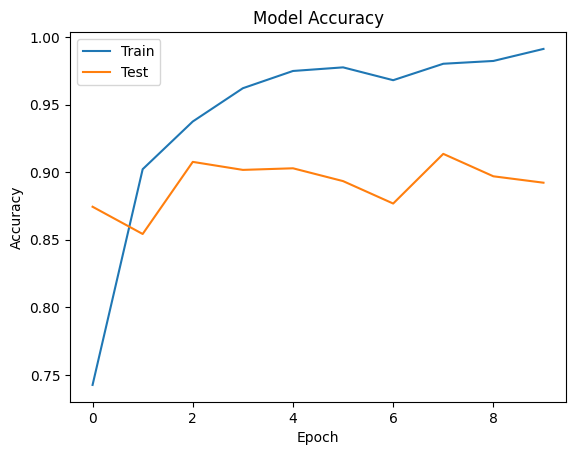

In [7]:

# Plot accuracy metrics
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()